<a href="https://colab.research.google.com/github/Sabbir-Hossain-A/credit_card_fraud_detection-/blob/main/credit_card_fraud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
#️⃣ Step 0: Install dependencies
!pip install pandas numpy matplotlib seaborn scikit-learn imbalanced-learn tensorflow --quiet

In [7]:
#️⃣ Step 1: Import libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_fscore_support, auc, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras.backend as K


# Config
RANDOM_STATE = 42
TEST_SIZE = 0.2
EPOCHS = 30
BATCH_SIZE = 1024

In [8]:
#️⃣ Step 2: Load Dataset
#from google.colab import files
#print("📂 Upload the creditcard.csv file (from Kaggle dataset)")
#uploaded = files.upload()


df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/creditcard.csv")
print("✅ Data loaded successfully.")
print("Rows:", len(df))
print(df.head())

✅ Data loaded successfully.
Rows: 284807
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.20

In [9]:
#️⃣ Step 4: Check Missing Values
print("\nMissing Values:")
print(df.isna().sum())


Missing Values:
Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


Amount outlier range: [-101.75, 184.51]
✅ Outliers handled successfully.


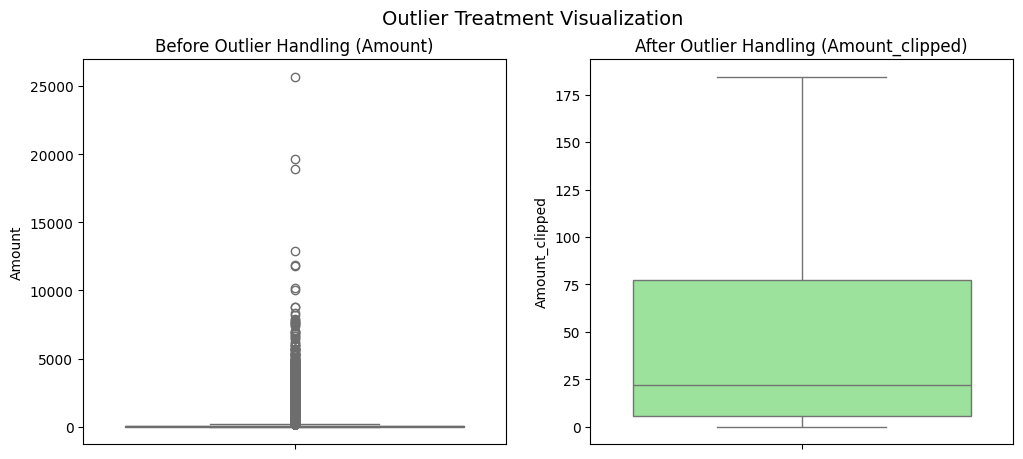

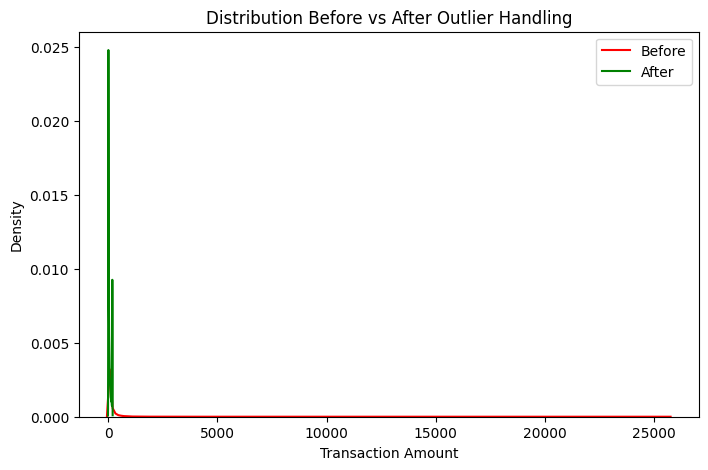

In [10]:
#️⃣ Step 5: Handle Outliers in Amount
Q1 = df['Amount'].quantile(0.25)
Q3 = df['Amount'].quantile(0.75)
IQR = Q3 - Q1
lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR

# Clip outliers
df['Amount_clipped'] = df['Amount'].clip(lower, upper)

print(f"Amount outlier range: [{lower:.2f}, {upper:.2f}]")
print("✅ Outliers handled successfully.")

# 🔍 Visualization: Before vs After
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.boxplot(y=df['Amount'], ax=ax[0], color='salmon')
ax[0].set_title('Before Outlier Handling (Amount)')

sns.boxplot(y=df['Amount_clipped'], ax=ax[1], color='lightgreen')
ax[1].set_title('After Outlier Handling (Amount_clipped)')

plt.suptitle('Outlier Treatment Visualization', fontsize=14)
plt.show()

# Optional: Compare distributions
plt.figure(figsize=(8,5))
sns.kdeplot(df['Amount'], label='Before', color='r')
sns.kdeplot(df['Amount_clipped'], label='After', color='g')
plt.title('Distribution Before vs After Outlier Handling')
plt.xlabel('Transaction Amount')
plt.legend()
plt.show()


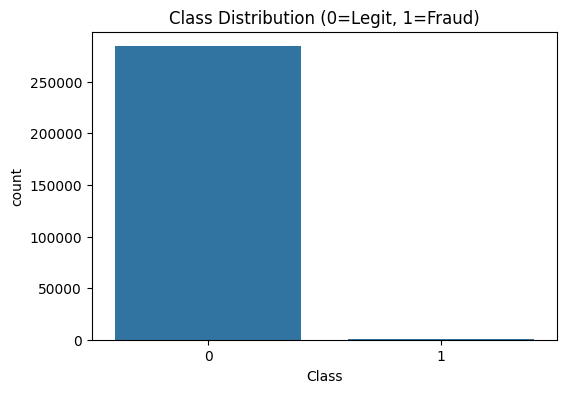

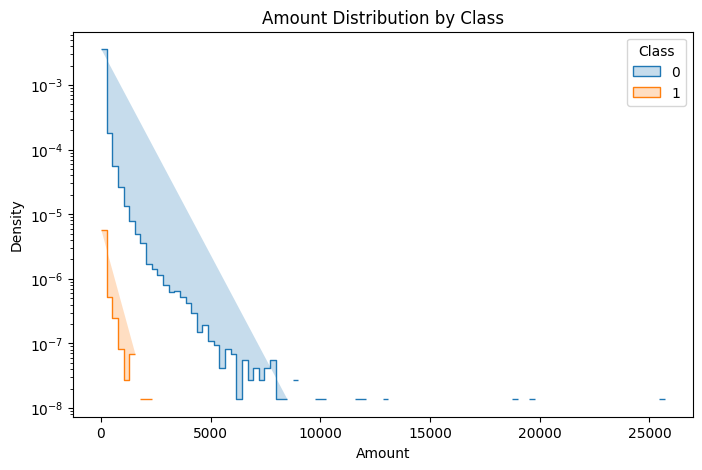

In [11]:
#️⃣ Step 6: Exploratory Data Analysis (EDA)
plt.figure(figsize=(6,4))
sns.countplot(x='Class', data=df)
plt.title('Class Distribution (0=Legit, 1=Fraud)')
plt.show()


plt.figure(figsize=(8,5))
sns.histplot(data=df, x='Amount', bins=100, hue='Class', element='step', stat='density', log_scale=(False, True))
plt.title('Amount Distribution by Class')
plt.show()

In [12]:
#️⃣ Step 7: Feature Engineering
# Rolling mean of previous 10 transaction amounts
df = df.sort_values('Time').reset_index(drop=True)
df['rolling_amount_mean_10'] = df['Amount'].rolling(window=10, min_periods=1).mean().shift(1).fillna(0)


FEATURES = ['Time','Amount_clipped','rolling_amount_mean_10'] + [c for c in df.columns if c.startswith('V')]
TARGET = 'Class'

In [13]:
#️⃣ Step 8: Scaling
scaler_time_amount = RobustScaler()
scaler_pca = StandardScaler()


df[['Time_scaled','Amount_scaled']] = scaler_time_amount.fit_transform(df[['Time','Amount_clipped']])
df[[c for c in df.columns if c.startswith('V')]] = scaler_pca.fit_transform(df[[c for c in df.columns if c.startswith('V')]])
df['rolling_amount_mean_10'] = RobustScaler().fit_transform(df[['rolling_amount_mean_10']])


FEATURES = ['Time_scaled','Amount_scaled','rolling_amount_mean_10'] + [c for c in df.columns if c.startswith('V')]

In [14]:
#️⃣ Step 9: Time-based Split
split_idx = int((1-TEST_SIZE)*len(df))
train_df = df.iloc[:split_idx]
test_df = df.iloc[split_idx:]


X_train, y_train = train_df[FEATURES].values, train_df[TARGET].values
X_test, y_test = test_df[FEATURES].values, test_df[TARGET].values
print(f"Train size: {len(train_df)}, Test size: {len(test_df)}")

Train size: 227845, Test size: 56962


In [15]:
#️⃣ Step 10: Apply SMOTE
sm = SMOTE(random_state=RANDOM_STATE)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
print(pd.Series(y_train_res).value_counts())

0    227428
1    227428
Name: count, dtype: int64


In [16]:
#️⃣ Step 11: Helper Functions

def show_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(title)
    plt.show()


def plot_rocs(results):
    plt.figure(figsize=(7,5))
    for name, (y_true, y_score) in results.items():
        fpr, tpr, _ = roc_curve(y_true, y_score)
        plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc_score(y_true, y_score):.3f})")
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.legend()
    plt.title('ROC Curves')
    plt.show()


def build_mlp(input_dim):
    inp = keras.Input(shape=(input_dim,))
    x = layers.Dense(128, activation='relu')(inp)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(32, activation='relu')(x)
    out = layers.Dense(1, activation='sigmoid')(x)
    model = keras.Model(inputs=inp, outputs=out)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[keras.metrics.AUC(name='auc')])
    return model


Epoch 1/30
400/400 - 12s - 29ms/step - auc: 0.9924 - loss: 0.1058 - val_auc: 0.0000e+00 - val_loss: 0.0201
Epoch 2/30
400/400 - 3s - 8ms/step - auc: 0.9995 - loss: 0.0223 - val_auc: 0.0000e+00 - val_loss: 0.0033
Epoch 3/30
400/400 - 4s - 10ms/step - auc: 0.9997 - loss: 0.0108 - val_auc: 0.0000e+00 - val_loss: 0.0016
Epoch 4/30
400/400 - 4s - 10ms/step - auc: 0.9998 - loss: 0.0070 - val_auc: 0.0000e+00 - val_loss: 0.0014
Epoch 5/30
400/400 - 6s - 14ms/step - auc: 0.9998 - loss: 0.0053 - val_auc: 0.0000e+00 - val_loss: 0.0012
Epoch 6/30
400/400 - 9s - 22ms/step - auc: 0.9998 - loss: 0.0044 - val_auc: 0.0000e+00 - val_loss: 3.6870e-04
Epoch 7/30
400/400 - 5s - 13ms/step - auc: 0.9998 - loss: 0.0037 - val_auc: 0.0000e+00 - val_loss: 3.6898e-04
Epoch 8/30
400/400 - 4s - 10ms/step - auc: 0.9999 - loss: 0.0031 - val_auc: 0.0000e+00 - val_loss: 3.5866e-04
Epoch 9/30
400/400 - 4s - 11ms/step - auc: 0.9999 - loss: 0.0029 - val_auc: 0.0000e+00 - val_loss: 3.4501e-04
Epoch 10/30
400/400 - 7s - 17m

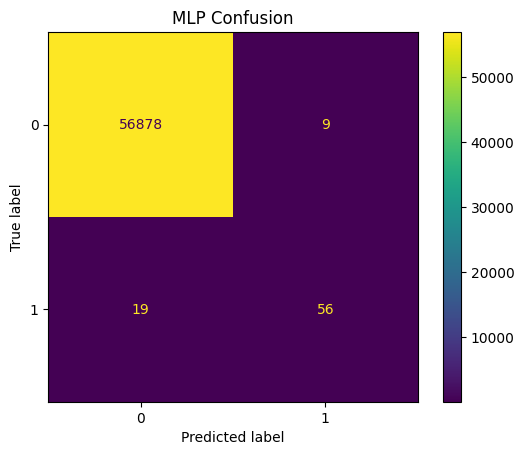

In [17]:
#️⃣ Step 12: Model 1 - MLP
mlp = build_mlp(X_train_res.shape[1])
mlp.fit(X_train_res, y_train_res, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.1, verbose=2)


mlp_probs = mlp.predict(X_test).ravel()
mlp_preds = (mlp_probs>=0.5).astype(int)
print(classification_report(y_test, mlp_preds, digits=4))
show_confusion(y_test, mlp_preds, 'MLP Confusion')

Epoch 1/30
400/400 - 9s - 24ms/step - auc: 0.9897 - loss: 0.0134 - val_auc: 0.0000e+00 - val_loss: 0.0040
Epoch 2/30
400/400 - 3s - 9ms/step - auc: 0.9994 - loss: 0.0037 - val_auc: 0.0000e+00 - val_loss: 0.0012
Epoch 3/30
400/400 - 4s - 9ms/step - auc: 0.9997 - loss: 0.0020 - val_auc: 0.0000e+00 - val_loss: 5.4102e-04
Epoch 4/30
400/400 - 5s - 12ms/step - auc: 0.9998 - loss: 0.0013 - val_auc: 0.0000e+00 - val_loss: 2.3891e-04
Epoch 5/30
400/400 - 3s - 8ms/step - auc: 0.9999 - loss: 0.0010 - val_auc: 0.0000e+00 - val_loss: 2.5335e-04
Epoch 6/30
400/400 - 3s - 8ms/step - auc: 0.9999 - loss: 8.5061e-04 - val_auc: 0.0000e+00 - val_loss: 2.5169e-04
Epoch 7/30
400/400 - 4s - 10ms/step - auc: 0.9999 - loss: 6.8336e-04 - val_auc: 0.0000e+00 - val_loss: 2.9294e-04
Epoch 8/30
400/400 - 4s - 11ms/step - auc: 0.9999 - loss: 6.1471e-04 - val_auc: 0.0000e+00 - val_loss: 2.5227e-04
Epoch 9/30
400/400 - 3s - 9ms/step - auc: 0.9999 - loss: 5.2984e-04 - val_auc: 0.0000e+00 - val_loss: 1.6942e-04
Epoch 1

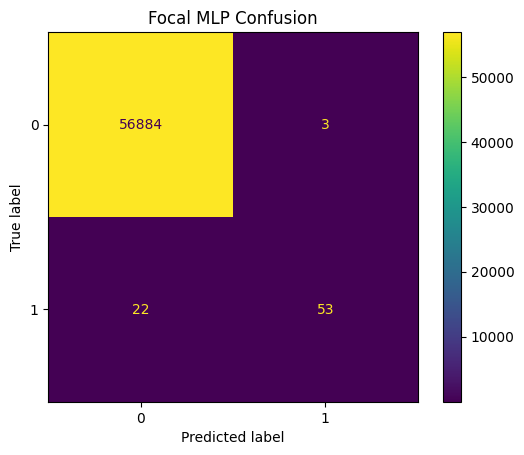

In [20]:
#️⃣ Step 13: Model 2 - MLP + Focal Loss

def focal_loss(gamma=2., alpha=.25):
    # Inner function properly indented
    def focal_loss_fixed(y_true, y_pred):
        y_true = K.cast(y_true, K.floatx())
        bce = K.binary_crossentropy(y_true, y_pred)
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        alpha_factor = y_true * alpha + (1 - y_true) * (1 - alpha)
        mod_factor = K.pow((1 - p_t), gamma)
        return K.mean(alpha_factor * mod_factor * bce)

    return focal_loss_fixed


# Build and compile model with focal loss
mlp_focal = build_mlp(X_train_res.shape[1])
mlp_focal.compile(optimizer='adam', loss=focal_loss(), metrics=[keras.metrics.AUC(name='auc')])

# Train model
mlp_focal.fit(
    X_train_res, y_train_res,
    epochs=EPOCHS, batch_size=BATCH_SIZE,
    validation_split=0.1, verbose=2
)

# Evaluate
mlp_focal_probs = mlp_focal.predict(X_test).ravel()
mlp_focal_preds = (mlp_focal_probs >= 0.5).astype(int)

print(classification_report(y_test, mlp_focal_preds, digits=4))
show_confusion(y_test, mlp_focal_preds, 'Focal MLP Confusion')


Epoch 1/30
100/100 - 4s - 38ms/step - loss: 0.7611 - val_loss: 0.7331
Epoch 2/30
100/100 - 1s - 11ms/step - loss: 0.4366 - val_loss: 0.4871
Epoch 3/30
100/100 - 1s - 10ms/step - loss: 0.3024 - val_loss: 0.3652
Epoch 4/30
100/100 - 1s - 9ms/step - loss: 0.2383 - val_loss: 0.2978
Epoch 5/30
100/100 - 1s - 9ms/step - loss: 0.1962 - val_loss: 0.2544
Epoch 6/30
100/100 - 1s - 10ms/step - loss: 0.1681 - val_loss: 0.2206
Epoch 7/30
100/100 - 1s - 10ms/step - loss: 0.1485 - val_loss: 0.1983
Epoch 8/30
100/100 - 1s - 9ms/step - loss: 0.1352 - val_loss: 0.1813
Epoch 9/30
100/100 - 1s - 9ms/step - loss: 0.1246 - val_loss: 0.1681
Epoch 10/30
100/100 - 1s - 12ms/step - loss: 0.1155 - val_loss: 0.1570
Epoch 11/30
100/100 - 1s - 13ms/step - loss: 0.1075 - val_loss: 0.1461
Epoch 12/30
100/100 - 1s - 10ms/step - loss: 0.1007 - val_loss: 0.1365
Epoch 13/30
100/100 - 2s - 16ms/step - loss: 0.0955 - val_loss: 0.1300
Epoch 14/30
100/100 - 2s - 20ms/step - loss: 0.0910 - val_loss: 0.1262
Epoch 15/30
100/100

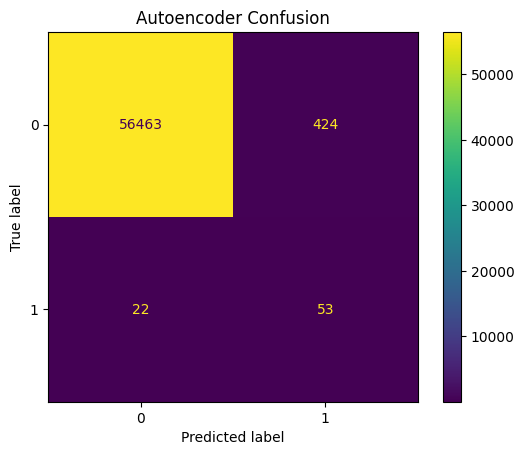

In [21]:
#️⃣ Step 14: Model 3 - Autoencoder (Unsupervised)
X_train_nf = train_df[train_df['Class']==0][FEATURES].values
input_dim = X_train_nf.shape[1]
inp = keras.Input(shape=(input_dim,))
encoded = layers.Dense(64, activation='relu')(inp)
encoded = layers.Dense(32, activation='relu')(encoded)
encoded = layers.Dense(16, activation='relu')(encoded)
decoded = layers.Dense(32, activation='relu')(encoded)
decoded = layers.Dense(64, activation='relu')(decoded)
out = layers.Dense(input_dim, activation='linear')(decoded)


AE = keras.Model(inputs=inp, outputs=out)
AE.compile(optimizer='adam', loss='mse')
AE.fit(X_train_nf, X_train_nf, epochs=EPOCHS, batch_size=2048, validation_split=0.1, verbose=2)


recon = AE.predict(X_test)
mse = np.mean(np.square(recon - X_test), axis=1)
threshold = np.mean(mse)+3*np.std(mse)
ae_preds = (mse>threshold).astype(int)
print(classification_report(y_test, ae_preds, digits=4))
show_confusion(y_test, ae_preds, 'Autoencoder Confusion')

Epoch 1/30
800/800 - 24s - 30ms/step - auc: 0.9575 - loss: 0.2170 - val_auc: 0.0000e+00 - val_loss: 0.2218
Epoch 2/30
800/800 - 42s - 52ms/step - auc: 0.9839 - loss: 0.1415 - val_auc: 0.0000e+00 - val_loss: 0.1901
Epoch 3/30
800/800 - 20s - 24ms/step - auc: 0.9920 - loss: 0.1076 - val_auc: 0.0000e+00 - val_loss: 0.1207
Epoch 4/30
800/800 - 19s - 24ms/step - auc: 0.9954 - loss: 0.0857 - val_auc: 0.0000e+00 - val_loss: 0.1110
Epoch 5/30
800/800 - 21s - 26ms/step - auc: 0.9969 - loss: 0.0716 - val_auc: 0.0000e+00 - val_loss: 0.0652
Epoch 6/30
800/800 - 19s - 24ms/step - auc: 0.9977 - loss: 0.0613 - val_auc: 0.0000e+00 - val_loss: 0.0652
Epoch 7/30
800/800 - 22s - 28ms/step - auc: 0.9982 - loss: 0.0536 - val_auc: 0.0000e+00 - val_loss: 0.0244
Epoch 8/30
800/800 - 20s - 25ms/step - auc: 0.9985 - loss: 0.0472 - val_auc: 0.0000e+00 - val_loss: 0.0289
Epoch 9/30
800/800 - 21s - 26ms/step - auc: 0.9987 - loss: 0.0422 - val_auc: 0.0000e+00 - val_loss: 0.0508
Epoch 10/30
800/800 - 19s - 24ms/step

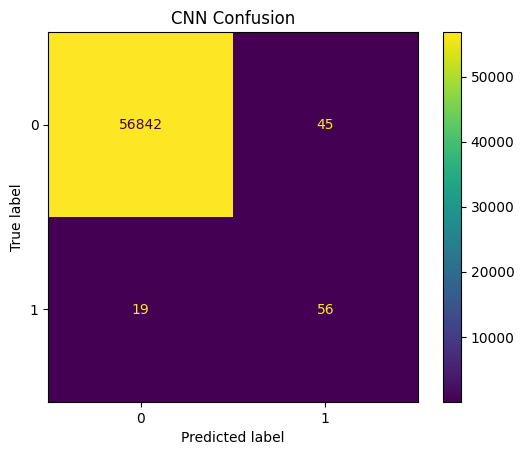

In [24]:
#️⃣ Step 15: Model 4 - 1D CNN

# Reshape data for CNN
X_train_cnn = X_train_res.reshape((-1, input_dim, 1))
X_test_cnn = X_test.reshape((-1, input_dim, 1))

# Build CNN model
def build_cnn(input_shape):
    inp = keras.Input(shape=input_shape)
    x = layers.Conv1D(64, 3, activation='relu')(inp)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Conv1D(32, 3, activation='relu')(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(32, activation='relu')(x)
    out = layers.Dense(1, activation='sigmoid')(x)
    model = keras.Model(inputs=inp, outputs=out)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[keras.metrics.AUC(name='auc')])
    return model

# Train CNN
cnn = build_cnn((input_dim, 1))
cnn.fit(X_train_cnn, y_train_res, epochs=EPOCHS, batch_size=512, validation_split=0.1, verbose=2)

# Predict and evaluate
cnn_probs = cnn.predict(X_test_cnn).ravel()
cnn_preds = (cnn_probs >= 0.5).astype(int)
print(classification_report(y_test, cnn_preds, digits=4))
show_confusion(y_test, cnn_preds, 'CNN Confusion')


7121/7121 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
Epoch 1/30
400/400 - 5s - 13ms/step - auc: 0.9945 - loss: 0.0918 - val_auc: 0.0000e+00 - val_loss: 0.0120
Epoch 2/30
400/400 - 4s - 10ms/step - auc: 0.9996 - loss: 0.0163 - val_auc: 0.0000e+00 - val_loss: 0.0026
Epoch 3/30
400/400 - 4s - 11ms/step - auc: 0.9997 - loss: 0.0080 - val_auc: 0.0000e+00 - val_loss: 0.0013
Epoch 4/30
400/400 - 3s - 9ms/step - auc: 0.9998 - loss: 0.0056 - val_auc: 0.0000e+00 - val_loss: 0.0032
Epoch 5/30
400/400 - 4s - 9ms/step - auc: 0.9998 - loss: 0.0042 - val_auc: 0.0000e+00 - val_loss: 5.9008e-04
Epoch 6/30
400/400 - 5s - 13ms/step - auc: 0.9998 - loss: 0.0038 - val_auc: 0.0000e+00 - val_loss: 0.0040
Epoch 7/30
400/400 - 3s - 9ms/step - auc: 0.9999 - loss: 0.0027 - val_auc: 0.0000e+00 - val_loss: 5.9820e-04
Epoch 8/30
400/400 - 3s - 9ms/step - auc: 0.9999 - loss: 0.0027 - val_auc: 0.0000e+00 - val_loss: 7.5094e-04
Epoch 9/30
400/400 - 4s - 9ms/step - auc: 0.9999 - loss: 

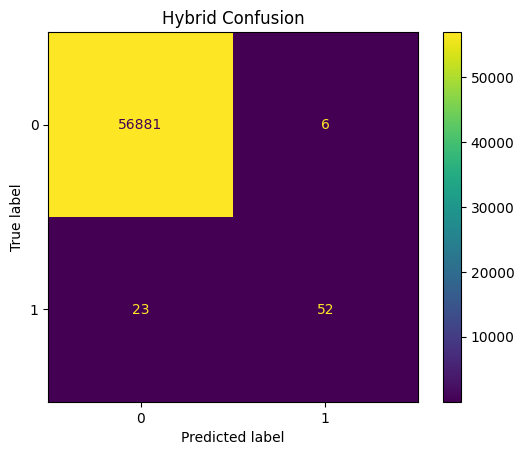

In [25]:
#️⃣ Step 16: Hybrid (AE-score + MLP)
train_recon = AE.predict(X_train)
train_mse = np.mean(np.square(train_recon - X_train), axis=1)
test_recon = AE.predict(X_test)
test_mse = np.mean(np.square(test_recon - X_test), axis=1)


X_train_h = np.hstack([X_train, train_mse.reshape(-1,1)])
X_test_h = np.hstack([X_test, test_mse.reshape(-1,1)])


sm2 = SMOTE(random_state=RANDOM_STATE)
Xh_res, yh_res = sm2.fit_resample(X_train_h, y_train)


hybrid = build_mlp(Xh_res.shape[1])
hybrid.fit(Xh_res, yh_res, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.1, verbose=2)


hyb_probs = hybrid.predict(X_test_h).ravel()
hyb_preds = (hyb_probs>=0.5).astype(int)
print(classification_report(y_test, hyb_preds, digits=4))
show_confusion(y_test, hyb_preds, 'Hybrid Confusion')

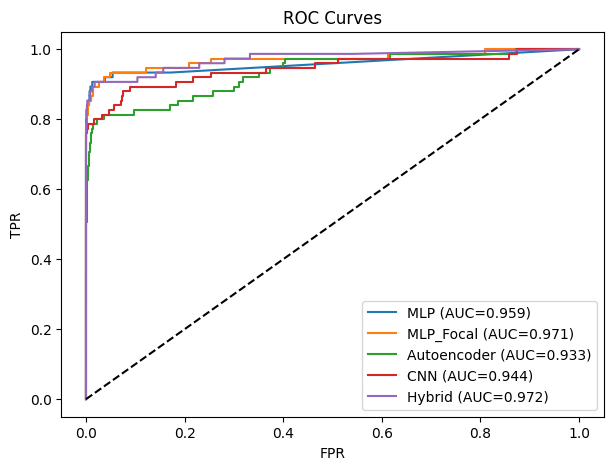

         Model  Precision    Recall        F1       AUC
0          MLP   0.861538  0.746667  0.800000  0.959077
1    MLP_Focal   0.946429  0.706667  0.809160  0.970942
2  Autoencoder   0.111111  0.706667  0.192029  0.932505
3          CNN   0.554455  0.746667  0.636364  0.944032
4       Hybrid   0.896552  0.693333  0.781955  0.972329
📁 model_performance_summary.csv saved
✅ All steps completed successfully.


In [28]:
#️⃣ Step 17: Compare ROC-AUC
results = {
'MLP': (y_test, mlp_probs),
'MLP_Focal': (y_test, mlp_focal_probs),
'Autoencoder': (y_test, mse),
'CNN': (y_test, cnn_probs),
'Hybrid': (y_test, hyb_probs)
}
plot_rocs(results)


#️⃣ Step 18: Performance Summary
rows = []
for name, preds in {'MLP':mlp_preds,'MLP_Focal':mlp_focal_preds,'Autoencoder':ae_preds,'CNN':cnn_preds,'Hybrid':hyb_preds}.items():
    prec, rec, f1, _ = precision_recall_fscore_support(y_test, preds, average='binary', zero_division=0)
    aucs = roc_auc_score(y_test, results[name][1])
    rows.append({'Model':name,'Precision':prec,'Recall':rec,'F1':f1,'AUC':aucs})
summary = pd.DataFrame(rows)
print(summary)
summary.to_csv('model_performance_summary.csv', index=False)
print('📁 model_performance_summary.csv saved')


print('✅ All steps completed successfully.')